# **Advanced Machine Learning Techniques for Real Estate Value Estimation on Zillow: Leveraging Neural Networks and Traditional Models**

**Team:**

SINDHU NAGESHA - 017419987                                      
PRAYAG NIKUL PURANI - 017416737                 
SYED FARAAZ AHMED - 017428619             
SAI VIVEK CHUNDURI- 017435301

In [2]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

In [4]:
from datasets import load_dataset

#dataset2 = load_dataset("misikoff/zillow", 'home_values', trust_remote_code=True)
# Assuming 'misikoff/zillow' is the dataset and 'home_values' is a configuration or subset
dataset = load_dataset("misikoff/zillow", 'home_values')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for misikoff/zillow contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/misikoff/zillow
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/117912 [00:00<?, ? examples/s]

In [5]:
dataset.shape

{'train': (117912, 11)}

In [6]:
# Display the first few rows of the dataset to understand its structure
print(dataset["train"][0:5])

# Get a sense of the dataset features
print(dataset["train"].features)

{'Region ID': ['3', '3', '3', '3', '3'], 'Size Rank': [48, 48, 48, 48, 48], 'Region': ['Alaska', 'Alaska', 'Alaska', 'Alaska', 'Alaska'], 'Region Type': [4, 4, 4, 4, 4], 'State': ['Alaska', 'Alaska', 'Alaska', 'Alaska', 'Alaska'], 'Home Type': [3, 3, 3, 3, 3], 'Bedroom Count': [0, 0, 0, 0, 0], 'Date': [datetime.datetime(2000, 1, 31, 0, 0), datetime.datetime(2000, 2, 29, 0, 0), datetime.datetime(2000, 3, 31, 0, 0), datetime.datetime(2000, 4, 30, 0, 0), datetime.datetime(2000, 5, 31, 0, 0)], 'Bottom Tier ZHVI (Smoothed) (Seasonally Adjusted)': [None, None, None, None, None], 'Mid Tier ZHVI (Smoothed) (Seasonally Adjusted)': [81310.640625, 80419.765625, 80480.453125, 79799.203125, 79666.46875], 'Top Tier ZHVI (Smoothed) (Seasonally Adjusted)': [None, None, None, None, None]}
{'Region ID': Value(dtype='string', id='Region ID'), 'Size Rank': Value(dtype='int32', id='Size Rank'), 'Region': Value(dtype='string', id='Region'), 'Region Type': ClassLabel(names=['zip', 'city', 'county', 'msa', 's

In [28]:
dataset_dict = {}

configs = [
    "sales",
]
for config in configs:
    print(config)
    dataset_dict[config] = load_dataset("misikoff/zillow",
                                        config,
                                        trust_remote_code=True,
                                        download_mode="force_redownload"
                                        )

sales


Generating train split:   0%|          | 0/255024 [00:00<?, ? examples/s]

In [29]:
input_df = dataset_dict['sales']['train'].to_pandas()

# Convert list to dictionary with values as indices
my_dict = {value: index for index, value in enumerate(input_df['Date'].unique())}
input_df['time'] = input_df['Date'].map(my_dict)

input_df['Year'] = input_df['Date'].astype(str).str.slice(0, 4).astype(int)
input_df['Month'] = input_df['Date'].astype(str).str.slice(5, 7).astype(int)
input_df['Day'] = input_df['Date'].astype(str).str.slice(8, 10).astype(int)

input_df

,Region ID,Size Rank,Region,Region Type,State,Home Type,Date,Mean Sale to List Ratio (Smoothed),Median Sale to List Ratio,Median Sale Price,...,Median Sale to List Ratio (Smoothed),% Sold Below List,% Sold Below List (Smoothed),% Sold Above List,% Sold Above List (Smoothed),Mean Sale to List Ratio,time,Year,Month,Day
0,102001,0,United States,5,None,2,2008-02-02,NaN,NaN,172000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2008,2,2
1,102001,0,United States,5,None,2,2008-02-09,NaN,NaN,165400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2008,2,9
2,102001,0,United States,5,None,2,2008-02-16,NaN,NaN,168000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2008,2,16
3,102001,0,United States,5,None,2,2008-02-23,NaN,NaN,167600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2008,2,23
4,102001,0,United States,5,None,2,2008-03-01,NaN,NaN,168100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4,2008,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255019,845160,198,"Prescott Valley, AZ",3,AZ,3,2023-11-11,0.978546,0.985132,515000.0,...,0.982460,0.680000,0.651221,0.080000,0.119711,0.983288,823,2023,11,11
255020,845160,198,"Prescott Valley, AZ",3,AZ,3,2023-11-18,0.972912,0.972559,510000.0,...,0.980362,0.625000,0.659583,0.142857,0.120214,0.958341,824,2023,11,18
255021,845160,198,"Prescott Valley, AZ",3,AZ,3,2023-11-25,0.971177,0.979644,484500.0,...,0.979179,0.705882,0.669387,0.088235,0.107185,0.973797,825,2023,11,25
255022,845160,198,"Prescott Valley, AZ",3,AZ,3,2023-12-02,0.970576,0.978261,538000.0,...,0.978899,0.704225,0.678777,0.126761,0.109463,0.966876,826,2023,12,2


In [30]:
input_df.columns

Index(['Region ID', 'Size Rank', 'Region', 'Region Type', 'State', 'Home Type',
       'Date', 'Mean Sale to List Ratio (Smoothed)',
       'Median Sale to List Ratio', 'Median Sale Price',
       'Median Sale Price (Smoothed) (Seasonally Adjusted)',
       'Median Sale Price (Smoothed)', 'Median Sale to List Ratio (Smoothed)',
       '% Sold Below List', '% Sold Below List (Smoothed)',
       '% Sold Above List', '% Sold Above List (Smoothed)',
       'Mean Sale to List Ratio', 'time', 'Year', 'Month', 'Day'],
      dtype='object')

In [31]:
input_df.shape

(255024, 22)

In [32]:
total_cells = np.product(input_df.shape)
total_missing = input_df.isnull().sum().sum()
percent_missing = (total_missing/total_cells) * 100
print("Percentage of missing values in the dataset: {:.2f}%".format(percent_missing))


Percentage of missing values in the dataset: 32.70%


In [33]:
#Checking the number of null values for each variable

input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 22 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   Region ID                                           255024 non-null  object        
 1   Size Rank                                           255024 non-null  int32         
 2   Region                                              255024 non-null  object        
 3   Region Type                                         255024 non-null  int64         
 4   State                                               253368 non-null  object        
 5   Home Type                                           255024 non-null  int64         
 6   Date                                                255024 non-null  datetime64[ms]
 7   Mean Sale to List Ratio (Smoothed)                  36794 non-null   float32       

In [34]:
input_df.to_csv('Zillow_hugging_face.csv')

In [35]:
# List of columns to be dropped
columns_to_drop = [
    'Mean Sale to List Ratio (Smoothed)',
    'Median Sale Price (Smoothed) (Seasonally Adjusted)',
    'Median Sale to List Ratio (Smoothed)',
    '% Sold Below List',
    '% Sold Below List (Smoothed)',
    '% Sold Above List',
    '% Sold Above List (Smoothed)'
]

# Drop the specified columns
input_df.drop(columns=columns_to_drop, inplace=True)

In [36]:
# List of columns to be dropped
columns_to_drop = [
    'Mean Sale to List Ratio']

# Drop the specified columns
input_df.drop(columns=columns_to_drop, inplace=True)

In [37]:
input_df.columns

Index(['Region ID', 'Size Rank', 'Region', 'Region Type', 'State', 'Home Type',
       'Date', 'Median Sale to List Ratio', 'Median Sale Price',
       'Median Sale Price (Smoothed)', 'time', 'Year', 'Month', 'Day'],
      dtype='object')

In [46]:
total_cells = np.product(input_df.shape)
total_missing = input_df.isnull().sum().sum()
percent_missing = (total_missing/total_cells) * 100
print("Percentage of missing values in the dataset: {:.2f}%".format(percent_missing))

Percentage of missing values in the dataset: 7.15%


In [47]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Region ID                     255024 non-null  object        
 1   Size Rank                     255024 non-null  int32         
 2   Region                        255024 non-null  object        
 3   Region Type                   255024 non-null  int64         
 4   State                         253368 non-null  object        
 5   Home Type                     255024 non-null  int64         
 6   Date                          255024 non-null  datetime64[ms]
 7   Median Sale to List Ratio     37140 non-null   float32       
 8   Median Sale Price             237658 non-null  float32       
 9   Median Sale Price (Smoothed)  236829 non-null  float32       
 10  time                          255024 non-null  int64         
 11  Year         

In [40]:
#input_df.to_csv('Zillow_hugging_face_clean.csv')

In [48]:
# 'Median Sale Price' is the target variable
y = input_df['Median Sale Price']
X = input_df.drop(columns=['Median Sale Price'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['int32','int64', 'float64','float32']).columns

In [49]:
numerical_cols

Index(['Size Rank', 'Region Type', 'Home Type', 'Median Sale to List Ratio',
       'Median Sale Price (Smoothed)', 'time', 'Year', 'Month', 'Day'],
      dtype='object')

In [43]:
categorical_cols

Index(['Region ID', 'Region', 'State'], dtype='object')

In [50]:
# Fill NA values for 'Median Sale to List Ratio' and 'Median Sale Price (Smoothed)'
input_df['Median Sale to List Ratio'] = input_df['Median Sale to List Ratio'].fillna(input_df['Median Sale to List Ratio'].mean())
input_df['Median Sale Price (Smoothed)'] = input_df['Median Sale Price (Smoothed)'].fillna(input_df['Median Sale Price (Smoothed)'].mean())

In [52]:
total_cells = np.product(input_df.shape)
total_missing = input_df.isnull().sum().sum()
percent_missing = (total_missing/total_cells) * 100
print("Percentage of missing values in the dataset: {:.2f}%".format(percent_missing))

Percentage of missing values in the dataset: 0.53%


In [53]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Region ID                     255024 non-null  object        
 1   Size Rank                     255024 non-null  int32         
 2   Region                        255024 non-null  object        
 3   Region Type                   255024 non-null  int64         
 4   State                         253368 non-null  object        
 5   Home Type                     255024 non-null  int64         
 6   Date                          255024 non-null  datetime64[ms]
 7   Median Sale to List Ratio     255024 non-null  float32       
 8   Median Sale Price             237658 non-null  float32       
 9   Median Sale Price (Smoothed)  255024 non-null  float32       
 10  time                          255024 non-null  int64         
 11  Year         

# **DATA VISUALIZATION**

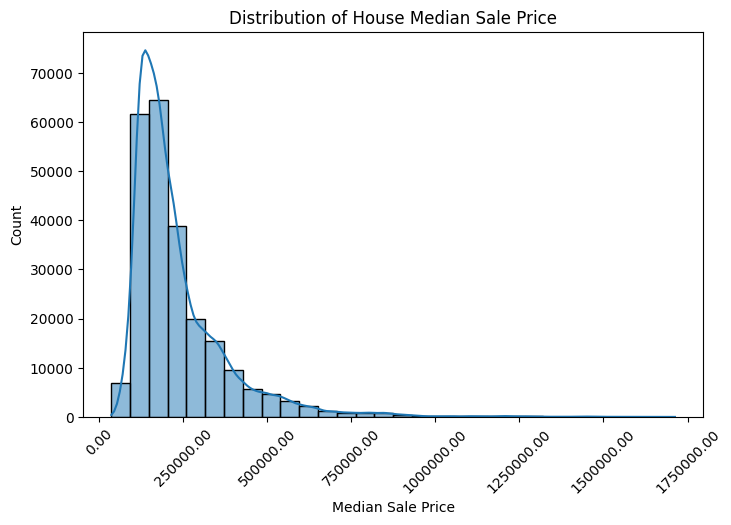

In [71]:
# Function to format tick labels with a specific number of decimal places
def plain_number_formatter(x, pos):
    return '{:.2f}'.format(x)

plt.figure(figsize=(8,5))
sns.histplot(input_df['Median Sale Price'], bins=30, kde=True)
plt.title('Distribution of House Median Sale Price')
plt.xlabel('Median Sale Price')
plt.ylabel('Count')

# Apply the custom formatter to the x-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(plain_number_formatter))

plt.xticks(rotation=45)
plt.show()

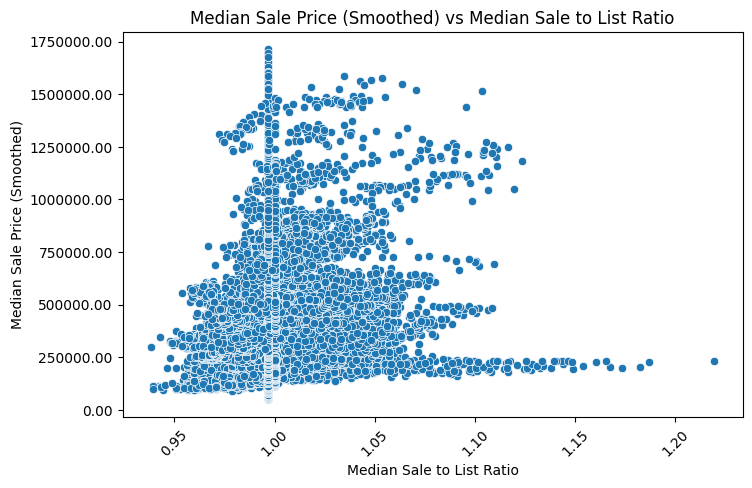

In [80]:
# Function to format tick labels as plain numbers with two decimal places
def plain_number_formatter(x, pos):
    return '{:.2f}'.format(x)

# Scatter Plot for 'Median Sale Price (Smoothed)' vs 'Median Sale to List Ratio'
plt.figure(figsize=(8,5))
sns.scatterplot(data=input_df, x='Median Sale to List Ratio', y='Median Sale Price (Smoothed)')
plt.title('Median Sale Price (Smoothed) vs Median Sale to List Ratio')
plt.xlabel('Median Sale to List Ratio')
plt.ylabel('Median Sale Price (Smoothed)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(plain_number_formatter))  # Format x-axis
plt.xticks(rotation=45)
plt.show()

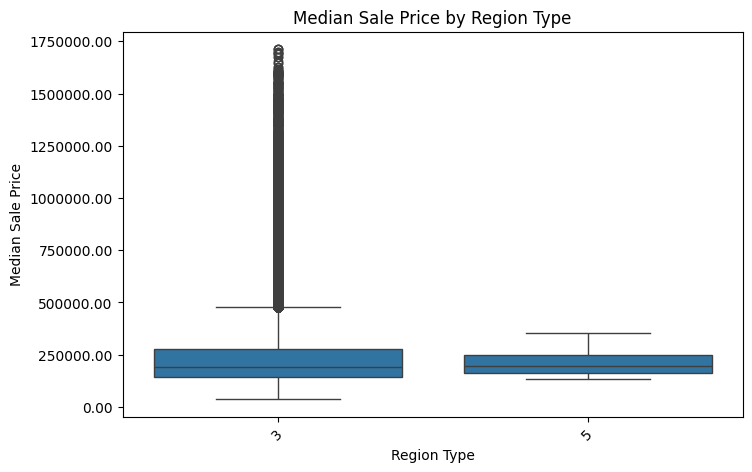

In [77]:
def plain_number_formatter(x, pos):
    return '{:.2f}'.format(x)
# Box Plot for 'Median Sale Price' by 'Region Type'
plt.figure(figsize=(8,5))
sns.boxplot(data=input_df, x='Region Type', y='Median Sale Price')
plt.title('Median Sale Price by Region Type')
plt.xlabel('Region Type')
plt.ylabel('Median Sale Price')
plt.gca().yaxis.set_major_formatter(FuncFormatter(plain_number_formatter))  # Format y-axis
plt.xticks(rotation=45)
plt.show()

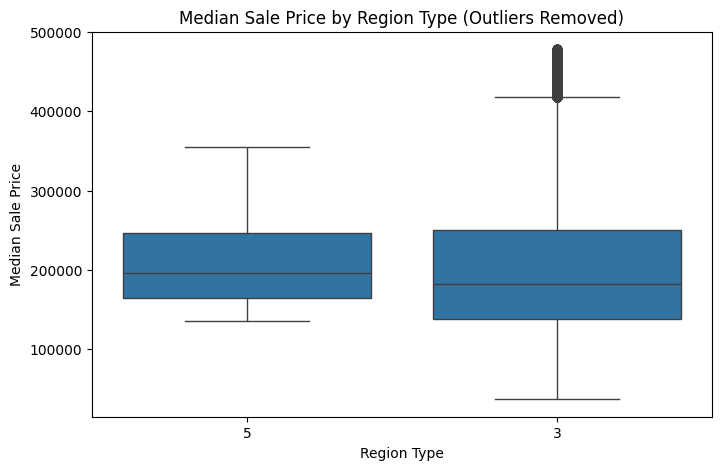

In [86]:
# Calculate the IQR
Q1 = input_df['Median Sale Price'].quantile(0.25)
Q3 = input_df['Median Sale Price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for what is considered an "outlier"
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_df = input_df[(input_df['Median Sale Price'] >= lower_bound) & (input_df['Median Sale Price'] <= upper_bound)]

# Plot without outliers
plt.figure(figsize=(8,5))
sns.boxplot(data=filtered_df, x='Region Type', y='Median Sale Price')
plt.title('Median Sale Price by Region Type (Outliers Removed)')
plt.xlabel('Region Type')
plt.ylabel('Median Sale Price')

plt.show()


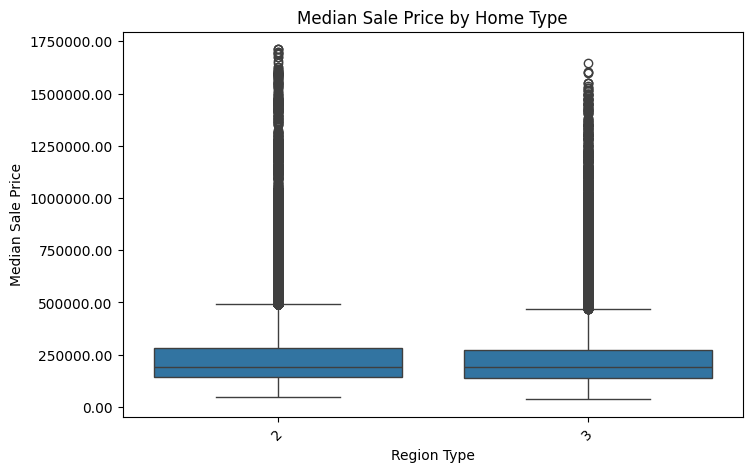

In [88]:
def plain_number_formatter(x, pos):
    return '{:.2f}'.format(x)
# Box Plot for 'Median Sale Price' by 'Region Type'
plt.figure(figsize=(8,5))
sns.boxplot(data=input_df, x='Home Type', y='Median Sale Price')
plt.title('Median Sale Price by Home Type')
plt.xlabel('Region Type')
plt.ylabel('Median Sale Price')
plt.gca().yaxis.set_major_formatter(FuncFormatter(plain_number_formatter))
plt.xticks(rotation=45)
plt.show()

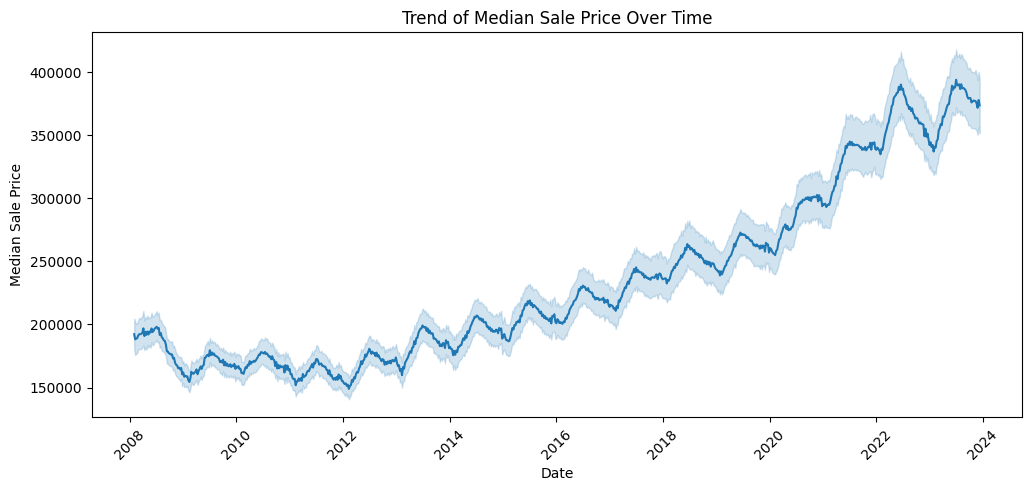

In [106]:
plt.figure(figsize=(12, 5))
input_df['Date'] = pd.to_datetime(input_df['Date'])  # Convert the date column to datetime if necessary
input_df.sort_values('Date', inplace=True)  # Sort by date
sns.lineplot(data=input_df, x='Date', y='Median Sale Price')
plt.title('Trend of Median Sale Price Over Time')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=45)
plt.show()

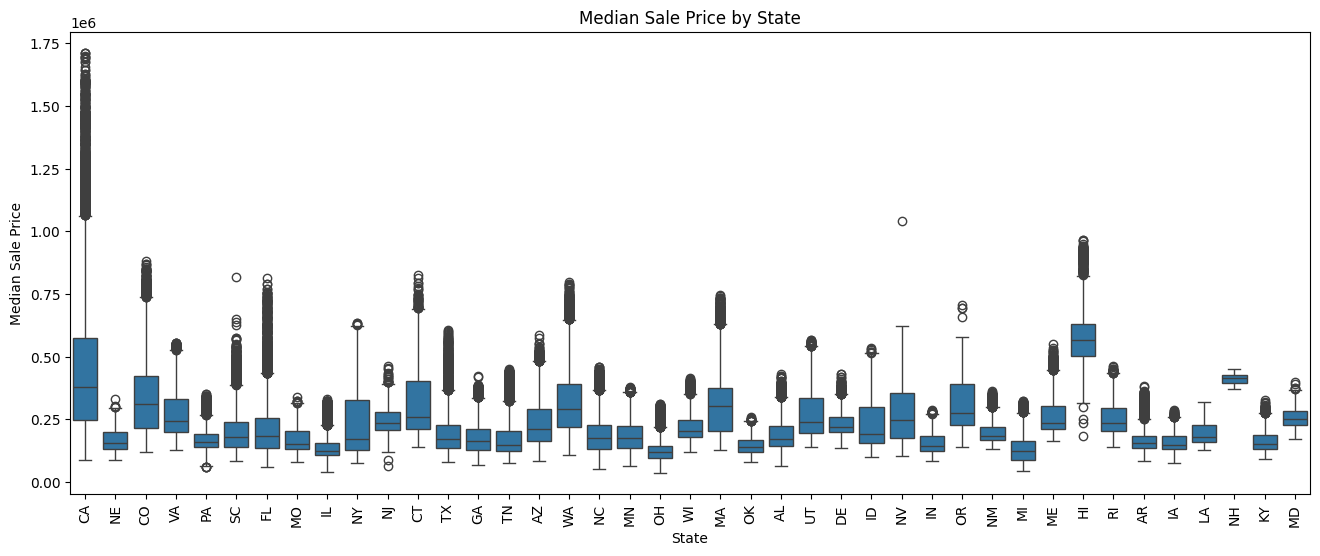

In [109]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=input_df, x='State', y='Median Sale Price')
plt.title('Median Sale Price by State')
plt.xlabel('State')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=90)  # Rotate the states for better readability
plt.show()

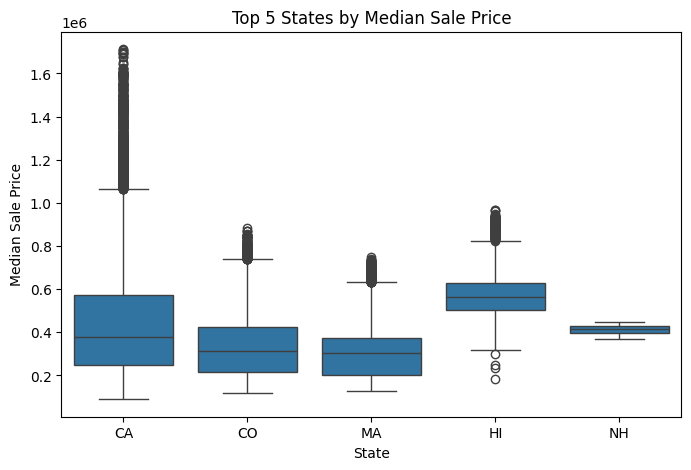

In [115]:
plt.figure(figsize=(8,5))
# Find the top 5 states with the highest median 'Median Sale Price'
top_5_states = input_df.groupby('State')['Median Sale Price'].median().sort_values(ascending=False).head(5).index
# Filter the DataFrame for only the top 5 states
top_5_df = input_df[input_df['State'].isin(top_5_states)]
sns.boxplot(data=top_5_df, x='State', y='Median Sale Price')
plt.title('Top 5 States by Median Sale Price')
plt.xlabel('State')
plt.ylabel('Median Sale Price')
plt.show()


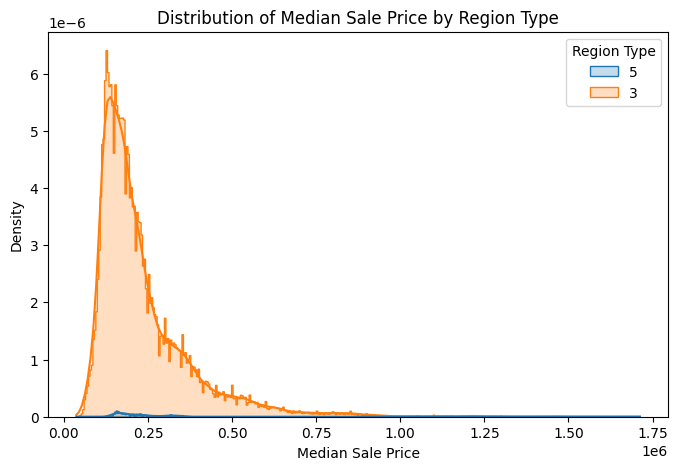

In [101]:
plt.figure(figsize=(8,5))
sns.histplot(data=input_df, x='Median Sale Price', hue='Region Type', kde=True, element='step', stat='density')
plt.title('Distribution of Median Sale Price by Region Type')
plt.xlabel('Median Sale Price')
plt.ylabel('Density')
plt.show()

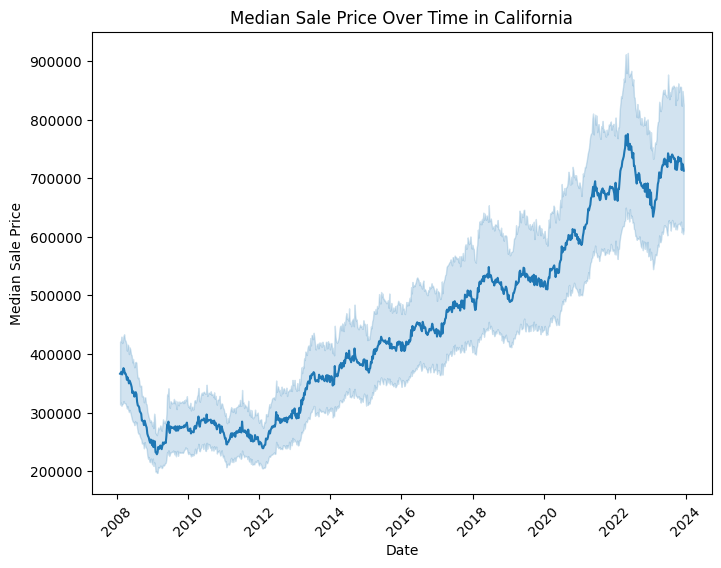

In [125]:
# Filter the dataset for California
california_df = input_df[input_df['State'] == 'CA']

# Time series plot for California
plt.figure(figsize=(8,6))
sns.lineplot(data=california_df, x='Date', y='Median Sale Price')
plt.title('Median Sale Price Over Time in California')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=45)
plt.show()


<ipython-input-128-7771a413d772>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california_df['Month'] = california_df['Date'].dt.month


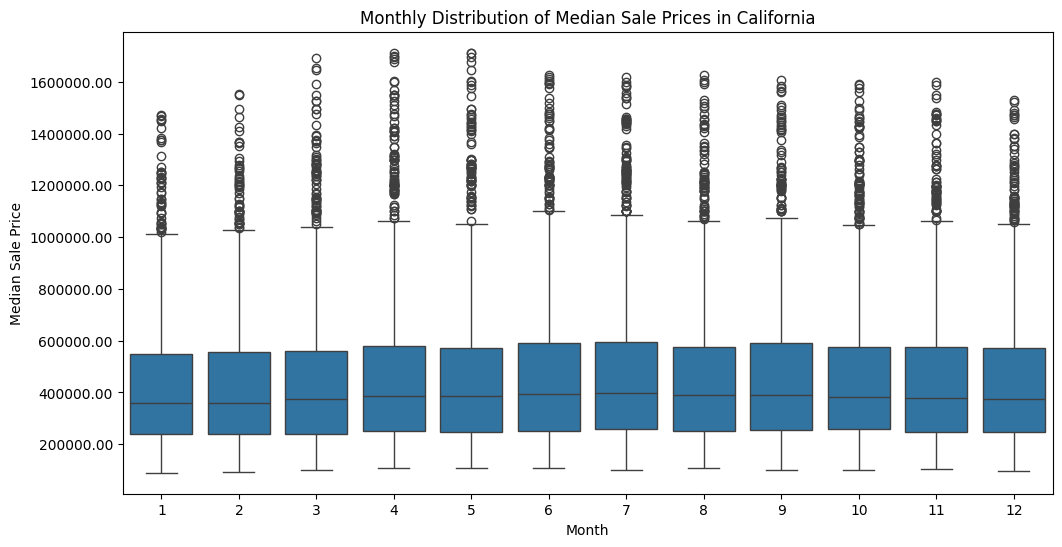

In [128]:
# Extract month from 'Date' for California
california_df['Month'] = california_df['Date'].dt.month

plt.figure(figsize=(12, 6))
sns.boxplot(data=california_df, x='Month', y='Median Sale Price')
plt.title('Monthly Distribution of Median Sale Prices in California')
plt.xlabel('Month')
plt.ylabel('Median Sale Price')
# Apply the custom formatter to the x-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(plain_number_formatter))
plt.show()


<ipython-input-137-487b5e3d4a77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california_df['Home Type'] = california_df['Home Type'].astype(str)  # Convert home type to string if it's not already


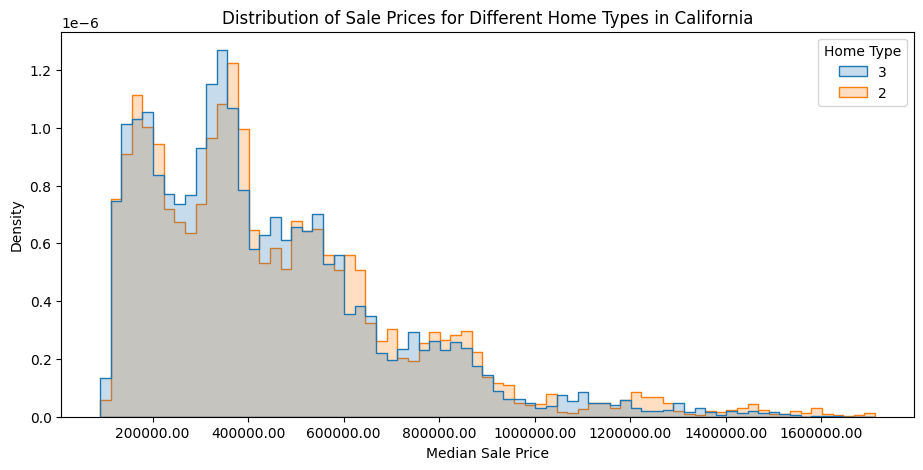

In [137]:
california_df['Home Type'] = california_df['Home Type'].astype(str)  # Convert home type to string if it's not already

plt.figure(figsize=(11,5))
sns.histplot(data=california_df, x='Median Sale Price', hue='Home Type', element='step', stat='density')
plt.title('Distribution of Sale Prices for Different Home Types in California')
plt.xlabel('Median Sale Price')
plt.ylabel('Density')
# Apply the custom formatter to the x-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(plain_number_formatter))
plt.show()


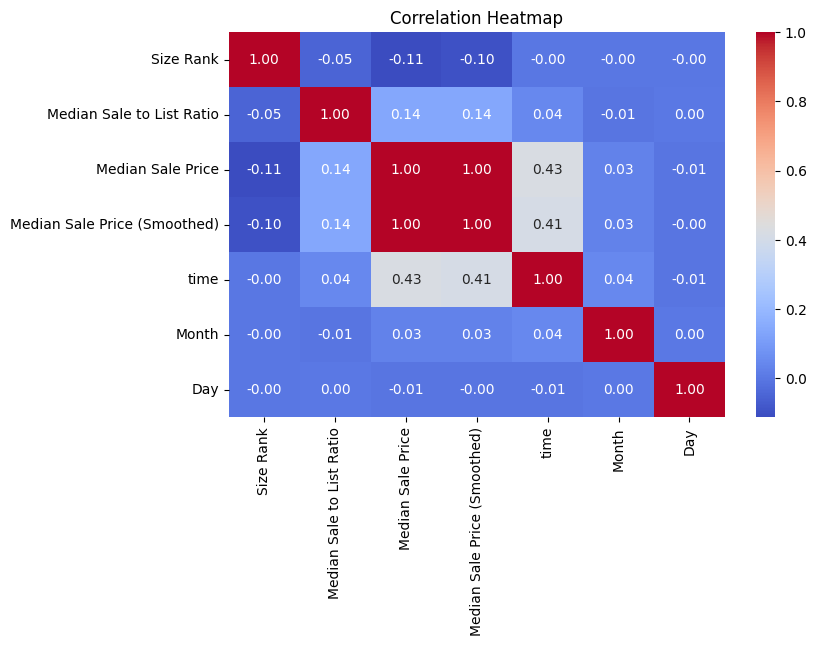

In [144]:
corr = input_df.select_dtypes(include=['float64', 'int64','int32','float32']).corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# **Model Training**


In [150]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Separate the features (X) and the target (y)
X = input_df.drop('Median Sale Price', axis=1)  # or the name of your target column
y = input_df['Median Sale Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a scaler
scaler = StandardScaler()

In [156]:
# Drop known non-numeric columns
X_dropped = X.drop(['Region ID', 'Region', 'State', 'Date'], axis=1)

# Check if there are any other non-numeric columns left
non_numeric_columns = X_dropped.select_dtypes(include=['object']).columns
print("Non-numeric columns still in the dataframe:", non_numeric_columns)

# Drop any additional non-numeric columns if they exist
X_dropped = X_dropped.drop(non_numeric_columns, axis=1)

# Confirm all columns are numeric now
print(X_dropped.dtypes)

# Now you can safely scale the features
X_train_scaled = scaler.fit_transform(X_dropped.loc[X_train.index])
X_test_scaled = scaler.transform(X_dropped.loc[X_test.index])

Non-numeric columns still in the dataframe: Index(['Region Type', 'Home Type', 'Year', 'YearMonth'], dtype='object')
Size Rank                         int32
Median Sale to List Ratio       float32
Median Sale Price (Smoothed)    float32
time                              int64
Month                             int64
Day                               int64
dtype: object
